In [113]:
import sys
sys.path += ['layers']
import numpy as np
from init_layers import init_layers
from init_model import init_model
from inference import inference
from loss_euclidean import loss_euclidean
from data_utils import get_CIFAR10_data

import pickle
import matplotlib.pyplot as plt

use_pcode = True
if use_pcode:
    # import the provided pyc implementation
    sys.path += ['pyc_code']
    from inference_ import inference
    from calc_gradient_ import calc_gradient
    from update_weights_ import update_weights
else:
    # import your own implementation
    from inference import inference
    from calc_gradient import calc_gradient
    from update_weights import update_weights

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
X_train, y_train, X_test, y_test = get_CIFAR10_data()

Train data shape:  (32, 32, 3, 50000)
Train labels shape:  (50000,)
Test data shape:  (32, 32, 3, 10000)
Test labels shape:  (10000,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9


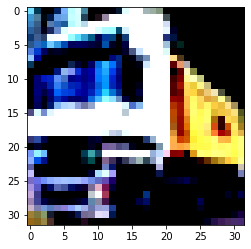

In [8]:
img = 1
plt.imshow(X_train[:,:,:,img])
print(y_train[img])

Simple example with linear function. Note shapes aren't correct to do backprop

In [34]:
from fn_linear_ import fn_linear
linear = init_layers("linear", {"num_in": 32, "num_out": 10})

In [35]:
linear.keys()

dict_keys(['fwd_fn', 'type', 'params', 'hyper_params'])

In [38]:
linear['fwd_fn']

<function fn_linear_.fn_linear(input, params, hyper_params, backprop, dv_output=None)>

In [32]:
linear['hyper_params']

{'num_in': 32, 'num_out': 10}

In [46]:
x = np.random.randn(32,1)

In [29]:
W = linear['params']['W'].shape
b = linear['params']['b'].shape

(10, 1)

In [30]:
y = linear['params']['W'] @ x + linear['params']['b']
y.shape

(32, 10, 1)

In [58]:
linear['fwd_fn'](x, linear['params'], linear['hyper_params'],backprop=False)

(array([[ 0.05682721],
        [-0.31463083],
        [ 1.17901568],
        [-0.2993785 ],
        [ 0.11107539],
        [-0.65765187],
        [ 0.08772662],
        [-0.62991493],
        [-1.04966365],
        [ 0.6350179 ]]),
 array([], dtype=float64),
 {'W': array([], dtype=float64), 'b': array([], dtype=float64)})

### Initializing a model

Basic size and content information can be seen below for each layer in the model. When the layer is initialized, the weights are also initialized for that layer.


In [114]:
l = [
    init_layers("conv", {"filter_size": 2, "filter_depth": 3, "num_filters": 2}),
    init_layers("pool", {"filter_size": 2, "stride": 2}),
    init_layers("relu", {}),
    init_layers("flatten", {}),
    init_layers("linear", {"num_in": 32, "num_out": 10}),
    init_layers("softmax", {}),
]

In [64]:
l[0].keys()

dict_keys(['fwd_fn', 'type', 'params', 'hyper_params'])

In [62]:
for layer in l:
    print(f"layer type: {layer['type']}")

layer type: conv
layer type: pool
layer type: relu
layer type: flatten
layer type: linear
layer type: softmax


In [65]:
for layer in l:
    print(f"layer type: {layer['fwd_fn']}")

layer type: <function fn_conv at 0x000002D8BBA638B8>
layer type: <function fn_pool at 0x000002D8AC7433A8>
layer type: <function fn_relu at 0x000002D8AC733D38>
layer type: <function fn_flatten at 0x000002D89E2A4318>
layer type: <function fn_linear at 0x000002D8AC87EEE8>
layer type: <function fn_softmax at 0x000002D8AC802F78>


In [66]:
for layer in l:
    print(f"layer params: {layer['params'].keys()}")

layer params: dict_keys(['W', 'b'])
layer params: dict_keys(['W', 'b'])
layer params: dict_keys(['W', 'b'])
layer params: dict_keys(['W', 'b'])
layer params: dict_keys(['W', 'b'])
layer params: dict_keys(['W', 'b'])


In [67]:
for layer in l:
    print(f"layer params: {layer['hyper_params'].keys()}")

layer params: dict_keys(['filter_size', 'filter_depth', 'num_filters'])
layer params: dict_keys(['filter_size', 'stride'])
layer params: dict_keys([])
layer params: dict_keys([])
layer params: dict_keys(['num_in', 'num_out'])
layer params: dict_keys([])


Now lets initialize a model with these layers.

In [74]:
model = init_model(
    layers=l,
    input_size=[10,10,3], # does not include batches only [H,W,D] 
    output_size=10, 
    display=True
    )

Input size:
[10, 10, 3]
Layer 0 output size: 
(9, 9, 2)
Layer 1 output size: 
(4, 4, 2)
Layer 2 output size: 
(4, 4, 2)
Layer 3 output size: 
(32,)
Layer 4 output size: 
(10,)
Final output size:
(10,)
Provided output size (should match above):
10
(Batch dimension not included)


In [75]:
model.keys()

dict_keys(['layers', 'input_size', 'output_size'])

In [91]:
layer_n = 0
print(f"layer {layer_n} dict: {model['layers'][layer_n].keys()}")
print(f"input size: {model['input_size']}")
print(f"output size: {model['output_size']}")

layer 0 dict: dict_keys(['fwd_fn', 'type', 'params', 'hyper_params'])
input size: [10, 10, 3]
output size: 10


### Run Inference (Forward pass)

In [116]:
                 # [H, W, Channels, Batch]
inp = np.random.rand(10, 10, 3, 4)  # Dummy input

In [117]:
output, activations = inference(model, inp)

In [118]:
print(f"output size: {output.shape}")

for ilayer, act in enumerate(activations):
    print(f"layer {ilayer} activation shape {act.shape}")

output size: (10, 4)
layer 0 activation shape (9, 9, 2, 4)
layer 1 activation shape (4, 4, 2, 4)
layer 2 activation shape (4, 4, 2, 4)
layer 3 activation shape (32, 4)
layer 4 activation shape (10, 4)
layer 5 activation shape (10, 4)


### Calculate loss

Stopping here- need to think about how to calcuate loss across a batch wrt to averaging

In [119]:
output.shape

(10, 4)

### Calculate Gradient

In [ ]:
# calc_gradient(model, inp, activations,)